
# Arguments

In [1]:
# vgg16-ft-pv-self-eb,ap,lm,ct
batch_size = 32
dataset_path_plantvillage = '../datasets/plantvillage'
dataset_path_self = '../datasets/self'
dataset_path_validation = '../datasets/validation'

dataset_paths = [dataset_path_plantvillage, dataset_path_self, dataset_path_validation]

model_save_path = 'model-warmup.h5'

checkpoint_path = 'checkpoints-warmup.hdf5'

input_width = 224
input_height = 224
input_depth = 3

# --------------------------------------------------
num_of_epochs = 25
start_epoch = 0
# --------------------------------------------------

# Print class names

In [2]:
# Get classes
import os
import re

class_names = []
class_paths_plant_village = []
class_paths_plant_self = []
class_paths_plant_validation = []

for path in dataset_paths:
    classes = os.listdir(path)
    for i in classes:
        if(re.search('___', i)):
            if(i not in class_names):
                class_names.append(i)
            if(re.search('plantvillage', path)):
                class_paths_plant_village.append(path + '/' + i)
            elif(re.search('self', path)):
                class_paths_plant_self.append(path + '/' + i)
            else:
                class_paths_plant_validation.append(path + '/' + i)

print(class_names)   
print()
print('PlantVillage')
print(class_paths_plant_village) 
print(len(class_paths_plant_village))
print()
print('Self')
print(class_paths_plant_self) 
print(len(class_paths_plant_self))
print()
print('Validation')
print(class_paths_plant_validation) 
print(len(class_paths_plant_validation))

['___Late_blight', '___Early_blight', '___Two-spotted_spider_mite', '___Yellow_Leaf_Curl_Virus', '___Leaf_Mold', '___Septoria_leaf_spot', '___healthy', '___Mosaic_Virus', '___Target_Spot', '___Bacterial_spot', '___Curly_top_virus', '___Leaf_miner', '___Appids']

PlantVillage
['../datasets/plantvillage/___Late_blight', '../datasets/plantvillage/___Early_blight', '../datasets/plantvillage/___Two-spotted_spider_mite', '../datasets/plantvillage/___Yellow_Leaf_Curl_Virus', '../datasets/plantvillage/___Leaf_Mold', '../datasets/plantvillage/___Septoria_leaf_spot', '../datasets/plantvillage/___healthy', '../datasets/plantvillage/___Mosaic_Virus', '../datasets/plantvillage/___Target_Spot', '../datasets/plantvillage/___Bacterial_spot']
10

Self
['../datasets/self/___Early_blight', '../datasets/self/___Curly_top_virus', '../datasets/self/___Leaf_miner', '../datasets/self/___Appids']
4

Validation
['../datasets/validation/___Late_blight', '../datasets/validation/___Early_blight', '../datasets/vali

# Select training classes

early blight in plantVillage dataset replaced by self one

In [3]:
class_paths_training = ['../datasets/self/___Early_blight', '../datasets/self/___Appids', '../datasets/self/___Leaf_miner', '../datasets/self/___Curly_top_virus']

# Load dataset

In [4]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image   import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.layers import Input
from keras.models import Model
from keras .applications import VGG16
from keras.optimizers import SGD
from keras.models import Model
from imutils import paths
import numpy as np
import os

import sys
sys.path.append('..')

from utils.preprocessors.resize_image_preprocessor import resizeImagePreprocessor
from utils.preprocessors.img_to_array_preprocessor import ImgToArrayPreprocessor
from utils.io.dataset_loader import DatasetLoader

# construct the image generator for data augmentation
aug = ImageDataGenerator(   rotation_range=30,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

def load_datasets(path_list):
    # Load image paths
    image_paths = []
    print("[INFO] loading images...")
    for path in path_list:
        image_paths.extend(list(paths.list_images(path)))
        
    # Get unique classnames

    class_names = [pt.split(os.path.sep)[-2] for pt in image_paths]
    class_names = [str(x) for x in np.unique(class_names)]

    # Initial image preprocessing
    aap = resizeImagePreprocessor(input_width, input_height)
    iap= ImgToArrayPreprocessor()

    #Load image data and perform image data preprocessing
    dl = DatasetLoader(preprocessors=[aap,iap])
    (data,labels)  = dl.load(image_paths,verbose=500)
    data = data.astype("float") / 255.0


    # train test split
    (train_x,test_x,train_y,test_y) = train_test_split(data,labels,test_size=0.25,random_state=42)

    # convert the labels from integers to vectors
    train_y = LabelBinarizer().fit_transform(train_y)
    test_y = LabelBinarizer().fit_transform(test_y)
    
    return (train_x,test_x,train_y,test_y, class_names)

(train_x,test_x,train_y,test_y, class_names) = load_datasets(class_paths_training)

Using TensorFlow backend.


[INFO] loading images...
[INFO]: Processed 500/4401
[INFO]: Processed 1000/4401
[INFO]: Processed 1500/4401
[INFO]: Processed 2000/4401
[INFO]: Processed 2500/4401
[INFO]: Processed 3000/4401
[INFO]: Processed 3500/4401
[INFO]: Processed 4000/4401



# Load model

In [5]:
from keras.applications import VGG16
from keras.utils.vis_utils import plot_model
from keras.layers import Input



# Load pretrianed VGG model with FC layers removed
# explicitly deﬁne the input_tensor to be 224×224×3 pixels
base_model = VGG16(weights='imagenet',include_top=False,
                  input_tensor=Input(shape = (input_width,input_height, input_depth)))

# plot_save_path = 'diagram-base-vgg16.png'
# plot_model(base_model, to_file=model_diagram_path, show_shapes=True)

58892288/58889256 [==============================] - 91s 2us/step


# Custom FC layer

In [6]:
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense

head_model = base_model.output
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(256,activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
# Add a softmaxc layer
head_model = Dense(len(class_names),activation='softmax')(head_model)

# plot_save_path = 'custom-head.png'
# plot_model(head_model, to_file=model_diagram_path, show_shapes=True)

# Attach custom head to model

In [7]:
from keras.models import Model


# place the head FC model on top of the base model 
model = Model(inputs=base_model.input, outputs = head_model)

# freeze weights in base model
for layer in base_model.layers:
    layer.trainable = False

# plot_save_path = 'diagram-vgg16-head-attached.png'
# plot_model(model, to_file=model_diagram_path, show_shapes=True)

# Freeze base model

In [8]:
# traverse all layers and freeze the weight of the corresponding layer
for layer in base_model.layers:
    layer.trainable = False

# Compile model

In [9]:
from keras.optimizers import SGD

# Build the model from the new
print("[INFO] re-compiling model ...")
opt = SGD(lr=0.001, momentum=0.09)

model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# Since we only train the new fully connected layer, we do a few iterations

[INFO] re-compiling model ...


# Checkpoints

In [10]:
from keras.callbacks import ModelCheckpoint


checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', 
save_best_only=True, verbose=1)

callbacks = [checkpoint]



In [11]:
#load checkpoints if existing

import os

if(os.path.exists(checkpoint_path)):
    model.load_weights(checkpoint_path)

# Training monitor

In [12]:
from utils.callbacks.monitor import Monitor
import pathlib
import json
import os

fig_path = "plot"
json_path = "values.json"
values_path = 'values.json'

callbacks.append(Monitor(fig_path, json_path, start_epoch))

# Warm up head

In [13]:
model.fit_generator(
    aug.flow(train_x,train_y, batch_size = batch_size),
             validation_data = (test_x,test_y),
             epochs=num_of_epochs,
             steps_per_epoch = len(train_x) //32,
             verbose = 1,
             callbacks=callbacks)

model.save(model_save_path)

Epoch 1/25
103/103 [==============================] - 39s 377ms/step - loss: 1.2440 - accuracy: 0.4458 - val_loss: 0.9557 - val_accuracy: 0.7375

Epoch 00001: val_loss improved from inf to 0.95568, saving model to checkpoints-warmup.hdf5
Epoch 2/25
103/103 [==============================] - 34s 333ms/step - loss: 0.9942 - accuracy: 0.6092 - val_loss: 0.7995 - val_accuracy: 0.7003

Epoch 00002: val_loss improved from 0.95568 to 0.79955, saving model to checkpoints-warmup.hdf5
Epoch 3/25
103/103 [==============================] - 34s 329ms/step - loss: 0.8583 - accuracy: 0.6613 - val_loss: 0.6525 - val_accuracy: 0.7856

Epoch 00003: val_loss improved from 0.79955 to 0.65250, saving model to checkpoints-warmup.hdf5
Epoch 4/25
103/103 [==============================] - 34s 329ms/step - loss: 0.7687 - accuracy: 0.7096 - val_loss: 0.6032 - val_accuracy: 0.8193

Epoch 00004: val_loss improved from 0.65250 to 0.60325, saving model to checkpoints-warmup.hdf5
Epoch 5/25
103/103 [================

# Evaluate with 20% test set from same dataset

In [14]:
from sklearn.metrics import classification_report

print("[INFO] evaluating with test set...")
predictions = model.predict(test_x,batch_size=32)
print(classification_report(test_y.argmax(axis =1),
                            predictions.argmax(axis =1),target_names=class_names))

[INFO] evaluating with test set...
                    precision    recall  f1-score   support

         ___Appids       0.88      0.99      0.93       243
___Curly_top_virus       0.89      0.68      0.77       109
   ___Early_blight       0.98      0.86      0.91       388
     ___Leaf_miner       0.87      0.98      0.92       361

          accuracy                           0.91      1101
         macro avg       0.91      0.88      0.88      1101
      weighted avg       0.91      0.91      0.91      1101



In [15]:
ev = model.evaluate(test_x, test_y)
acc = ev[1] * 100
print('accuracy : ' +  str("%.4f" % round(acc, 4)))

1101/1101 [==============================] - 5s 5ms/step
accuracy : 90.7357


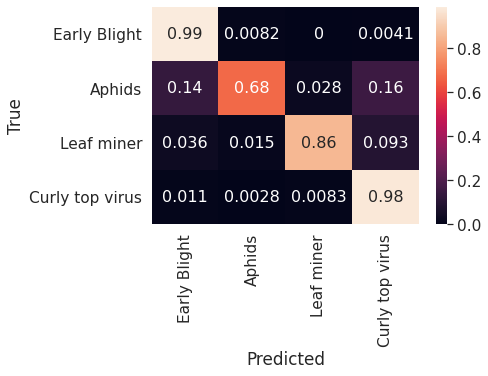

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

class_names = ['Early Blight', 'Aphids', 'Leaf miner', 'Curly top virus']

matrix = confusion_matrix(test_y.argmax(axis=1), predictions.argmax(axis=1))
matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(matrix_normalized, range(len(class_names)), range(len(class_names)))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=class_names, yticklabels=class_names) # font size


# Add axis labels
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# x is predicted
# y is true

# Evaluate with validation images

In [17]:
class_paths_validation = ['../datasets/validation/___Early_blight', '../datasets/validation/___Appids', '../datasets/validation/___Leaf_miner', '../datasets/self/___Curly_top_virus']

In [18]:
(train_x,test_x,train_y,test_y, class_names) = load_datasets(class_paths_validation)

from sklearn.metrics import classification_report

print("[INFO] evaluating with validation set...")
predictions = model.predict(test_x,batch_size=batch_size)

print(classification_report(test_y.argmax(axis =1),
                            predictions.argmax(axis =1),
                            target_names=class_names, 
                            digits=4))

[INFO] loading images...
[INFO]: Processed 500/599
[INFO] evaluating with validation set...
                    precision    recall  f1-score   support

         ___Appids     0.2000    0.4000    0.2667         5
___Curly_top_virus     0.9565    0.7857    0.8627       112
   ___Early_blight     0.5714    0.6667    0.6154        12
     ___Leaf_miner     0.5000    0.8095    0.6182        21

          accuracy                         0.7667       150
         macro avg     0.5570    0.6655    0.5907       150
      weighted avg     0.8366    0.7667    0.7888       150



In [19]:
ev = model.evaluate(test_x, test_y)
acc = ev[1] * 100
print('accuracy : ' +  str("%.4f" % round(acc, 4)))

150/150 [==============================] - 1s 5ms/step
accuracy : 76.6667


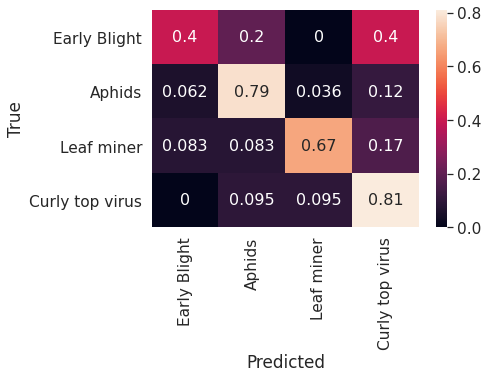

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

class_names = ['Early Blight', 'Aphids', 'Leaf miner', 'Curly top virus']

matrix = confusion_matrix(test_y.argmax(axis=1), predictions.argmax(axis=1))
matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(matrix_normalized, range(len(class_names)), range(len(class_names)))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=class_names, yticklabels=class_names) # font size


# Add axis labels
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# x is predicted
# y is true